**Imports and Model Setup**

In [1]:
import torch

print("PyTorch version:", torch.__version__)  # Should show CUDA version
print("CUDA version in PyTorch:", torch.version.cuda)  # Should match installed CUDA (e.g., 12.1)
print("CUDA available:", torch.cuda.is_available())  # Should return True
print("Number of GPUs:", torch.cuda.device_count())  # Should be > 0
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

PyTorch version: 2.5.1+cu121
CUDA version in PyTorch: 12.1
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 3060


In [ ]:
import wandb
BATCH_SIZE = 16
NUM_WORKERS = 0
NUM_EPOCHS = 40
LR_RATE = 5e-4
CHECKPOINT = "model/Vortex0217_01.pth"

CONFIG= { 

}

CONFIG["batch_size"] = BATCH_SIZE
CONFIG["learning_rate"] = LR_RATE
CONFIG["epochs"] = NUM_EPOCHS
CONFIG["architecture"] = "decoder finetuning"
CONFIG["dataset"] = "WebGL synthetic data"
CONFIG["scheduler"] = "CosineAnnealingLR
CONFIG["loss"] = "DiceBCELoss"
CONFIG["checkpoint"] = CHECKPOINT

wandb.init(
    project="contour segmentation",
    reinit=True,
    resume="never",
    config= CONFIG
)

wandb: Currently logged in as: jongwonsohn (jongwonsohn-seoul-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import timm.layers
import tqdm

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "model/MobileSAM_Vortex_checkpoint.pth"
device = "cpu"  # set device to cpu temporarily for dataset transforms

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)

predictor = SamPredictor(mobile_sam)
mask_generator = SamAutomaticMaskGenerator(mobile_sam)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\user\Documents\slurry_viscnet\MobileSAM_Vortex\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\user\Documents\slurry_viscnet

**Generate Dataset**

## Data

Preparing Data for training/validation (not yet test). Training and validation process using PyTorch requires two main implementations: `Dataset`, `Dataloader`.  

In [5]:
import os
import os.path as osp
import torch
import numpy as np
import cv2
from patchify import patchify
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import namedtuple
from PIL import Image

ImageMaskPathItem = namedtuple("ImageMaskPathItem", ["image_path", "mask_path"])

class ImageMaskDataset(Dataset):
    def __init__(self, root, image_subdir, mask_subdir, transform=None):
        super().__init__()
        self.root = root
        self.image_subdir = image_subdir
        self.mask_subdir = mask_subdir
        self.transform = transform

        images = glob.glob(osp.join(root, image_subdir, "*.png"))
        images = sorted(images)
        masks = [image.replace(image_subdir, mask_subdir) for image in images]

        self.path_items = [ImageMaskPathItem(image_path=image, mask_path=mask) for image, mask in zip(images, masks)]
        self._sanity_check()
        print(f"Found {len(self.path_items)} image-mask pairs")

    def _sanity_check(self):
        for item in self.path_items:
            assert osp.exists(item.image_path), f"Image path {item.image_path} does not exist"
            assert osp.exists(item.mask_path), f"Mask path {item.mask_path} does not exist"

    def __getitem__(self, index):
        item = self.path_items[index]
        image = np.array(Image.open(item.image_path).convert("RGB"))
        mask = np.array(Image.open(item.mask_path).convert("L"))
        # image = cv2.imread(item.image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # FIXME: Check if this is necessary
        # mask = cv2.imread(item.mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

    def __len__(self):
        return len(self.path_items)

In [6]:
import torch
from mobile_sam.utils import transforms
from torchvision import transforms as T
from torch.utils.data import Subset

import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose(
    [
        A.Normalize(max_pixel_value=255.0),
        ToTensorV2(),
    ], is_check_shapes = False #disabel size match verificaiton between img and mask
)

train_ds = ImageMaskDataset(root="processed_data", image_subdir="images", mask_subdir="masks", transform=transform)
val_ds = ImageMaskDataset(root="processed_data", image_subdir="images", mask_subdir="masks", transform=transform)

indices = np.arange(len(train_ds))
train_idx, val_idx = train_test_split(indices, test_size=0.2, shuffle=True, random_state=42)
train_ds = Subset(train_ds, train_idx)
val_ds = Subset(val_ds, val_idx)

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

print("Train dataset sample:")
print(train_ds[0][0].dtype)
print(train_ds[0][0].shape)
print(train_ds[0][1].shape)

Found 17837 image-mask pairs
Found 17837 image-mask pairs
Train dataset size: 14269
Validation dataset size: 3568
Train dataset sample:
torch.float32
torch.Size([3, 1024, 1024])
torch.Size([256, 256])


In [7]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

**Dataset Processor for MobileSAM**

In [8]:
from mobile_sam import sam_model_registry, SamPredictor

model_type = "vit_t"
sam_checkpoint = CHECKPOINT
device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry["vit_t"](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
predictor = SamPredictor(mobile_sam)

c:\Users\user\Documents\slurry_viscnet\MobileSAM_Vortex\mobile_sam\build_sam.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [9]:
# Freeze layers in MobileSAM
for name, param in mobile_sam.named_parameters():
    if name.startswith("image_encoder"):  # Assuming "image_encoder" corresponds to the vision encoder
        param.requires_grad = False  # Freeze the vision encoder
    elif name.startswith("prompt_encoder"):  # Assuming "prompt_encoder" exists in MobileSAM
        param.requires_grad = False  # Freeze the prompt encoder

# Verify trainable parameters
trainable_params = sum(p.numel() for p in mobile_sam.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# Iterate through all parameters and check their trainable status
print("MobileSAM Parameters:")
for name, param in mobile_sam.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Count the total trainable parameters
trainable_params = sum(p.numel() for p in mobile_sam.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters in MobileSAM: {trainable_params}")

Trainable parameters: 4058340
MobileSAM Parameters:
image_encoder.patch_embed.seq.0.c.weight: Frozen
image_encoder.patch_embed.seq.0.bn.weight: Frozen
image_encoder.patch_embed.seq.0.bn.bias: Frozen
image_encoder.patch_embed.seq.2.c.weight: Frozen
image_encoder.patch_embed.seq.2.bn.weight: Frozen
image_encoder.patch_embed.seq.2.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv1.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv1.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv1.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv2.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv2.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv2.bn.bias: Frozen
image_encoder.layers.0.blocks.0.conv3.c.weight: Frozen
image_encoder.layers.0.blocks.0.conv3.bn.weight: Frozen
image_encoder.layers.0.blocks.0.conv3.bn.bias: Frozen
image_encoder.layers.0.blocks.1.conv1.c.weight: Frozen
image_encoder.layers.0.blocks.1.conv1.bn.weight: Frozen
image_encoder.layers.0.blocks.1.conv1.bn.bias: F

**Training Loop**

In [10]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# Initialize the optimizer for the mask decoder
optimizer = Adam(mobile_sam.mask_decoder.parameters(), lr=LR_RATE, weight_decay=0)

from torch import nn
from torch.nn import functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction="mean")
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

seg_loss = DiceBCELoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

In [ ]:
import torch
from statistics import mean
from tqdm import tqdm

# Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
mobile_sam.to(device)
num_epochs = 40

mobile_sam.train()
for epoch in range(num_epochs):
    train_losses = []
    for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # stacking mask/training model/mask retrieve
        images, masks = batch
        images = images.to(device)
        masks = (masks / 255).round().float().to(device) 
        batched_input = [{"image": img, "original_size": (256, 256)} for img in images]
        outputs = mobile_sam(batched_input=batched_input, multimask_output=False)
        predicted_masks = torch.stack([output["masks"].squeeze(1).float() for output in outputs])

        # loss calculation/optimization
        train_loss = seg_loss(predicted_masks, masks)
        train_losses.append(train_loss.item())
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # loss print
        if (len(train_losses)) % 50 == 0:
            mean_train_loss = mean(train_losses)
            wandb.log({"train_loss": mean_train_loss})
    train_losses.clear()

    # Validation loss calculation
    mobile_sam.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(val_dl, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = batch
            images = images.to(device)
            masks = (masks / 255).round().float().to(device)
            batched_input = [{"image": img, "original_size": (256, 256)} for img in images]  
            outputs = mobile_sam(batched_input=batched_input, multimask_output=False)
            predicted_masks = torch.stack([output["masks"].squeeze(1).float() for output in outputs])
            val_loss = seg_loss(predicted_masks, masks)
            val_losses.append(val_loss.item())
    mean_val_loss = mean(val_losses)
    wandb.log({"val_loss": mean_val_loss})

    # Scheduler step
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    print(f"Epoch {epoch+1}/{num_epochs} results - Train Loss: {mean_train_loss:.4f} Validation Loss: {mean_val_loss:.4f} - LR: {current_lr:.5f}")
wandb.finish()

Epoch 1/40 - Validation: 100%|██████████| 223/223 [03:41<00:00,  1.01it/s]


Epoch 1/40 results - Train Loss: 0.7410 Validation Loss: 0.7730 - LR: 0.0005


Epoch 2/40 - Validation: 100%|██████████| 223/223 [03:41<00:00,  1.01it/s]


Epoch 2/40 results - Train Loss: 0.7304 Validation Loss: 0.7631 - LR: 0.0005


Epoch 3/40 - Validation: 100%|██████████| 223/223 [03:40<00:00,  1.01it/s]


Epoch 3/40 results - Train Loss: 0.7279 Validation Loss: 0.7645 - LR: 0.0005


Epoch 4/40 - Validation: 100%|██████████| 223/223 [03:40<00:00,  1.01it/s]


Epoch 4/40 results - Train Loss: 0.7240 Validation Loss: 0.7641 - LR: 0.0005


Epoch 5/40 - Validation: 100%|██████████| 223/223 [03:23<00:00,  1.10it/s]


Epoch 5/40 results - Train Loss: 0.7197 Validation Loss: 0.7634 - LR: 0.0005


Epoch 6/40 - Validation: 100%|██████████| 223/223 [03:23<00:00,  1.10it/s]


Epoch 6/40 results - Train Loss: 0.7182 Validation Loss: 0.7638 - LR: 0.0005


Epoch 7/40 - Validation: 100%|██████████| 223/223 [03:23<00:00,  1.10it/s]


Epoch 7/40 results - Train Loss: 0.7153 Validation Loss: 0.7601 - LR: 0.0005


Epoch 8/40 - Validation: 100%|██████████| 223/223 [03:23<00:00,  1.10it/s]


Epoch 8/40 results - Train Loss: 0.7094 Validation Loss: 0.7616 - LR: 0.0005


Epoch 9/40 - Validation: 100%|██████████| 223/223 [03:23<00:00,  1.10it/s]


Epoch 9/40 results - Train Loss: 0.7068 Validation Loss: 0.7607 - LR: 0.0005


Epoch 10/40 - Validation: 100%|██████████| 223/223 [03:23<00:00,  1.09it/s]


Epoch 10/40 results - Train Loss: 0.7037 Validation Loss: 0.7571 - LR: 0.0005


Epoch 11/40 - Validation: 100%|██████████| 223/223 [03:23<00:00,  1.10it/s]


Epoch 11/40 results - Train Loss: 0.7006 Validation Loss: 0.7583 - LR: 0.0004


Epoch 12/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 12/40 results - Train Loss: 0.6973 Validation Loss: 0.7569 - LR: 0.0004


Epoch 13/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 13/40 results - Train Loss: 0.6943 Validation Loss: 0.7563 - LR: 0.0004


Epoch 14/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 14/40 results - Train Loss: 0.6901 Validation Loss: 0.7564 - LR: 0.0004


Epoch 15/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 15/40 results - Train Loss: 0.6880 Validation Loss: 0.7555 - LR: 0.0004


Epoch 16/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 16/40 results - Train Loss: 0.6837 Validation Loss: 0.7576 - LR: 0.0004


Epoch 17/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 17/40 results - Train Loss: 0.6811 Validation Loss: 0.7584 - LR: 0.0004


Epoch 18/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 18/40 results - Train Loss: 0.6770 Validation Loss: 0.7545 - LR: 0.0004


Epoch 19/40 - Validation: 100%|██████████| 223/223 [03:25<00:00,  1.09it/s]


Epoch 19/40 results - Train Loss: 0.6742 Validation Loss: 0.7569 - LR: 0.0003


Epoch 20/40 - Validation: 100%|██████████| 223/223 [03:25<00:00,  1.09it/s]


Epoch 20/40 results - Train Loss: 0.6717 Validation Loss: 0.7555 - LR: 0.0003


Epoch 21/40 - Validation: 100%|██████████| 223/223 [03:25<00:00,  1.09it/s]


Epoch 21/40 results - Train Loss: 0.6678 Validation Loss: 0.7542 - LR: 0.0003


Epoch 22/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 22/40 results - Train Loss: 0.6652 Validation Loss: 0.7571 - LR: 0.0003


Epoch 23/40 - Validation: 100%|██████████| 223/223 [03:25<00:00,  1.09it/s]


Epoch 23/40 results - Train Loss: 0.6608 Validation Loss: 0.7565 - LR: 0.0003


Epoch 24/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 24/40 results - Train Loss: 0.6579 Validation Loss: 0.7567 - LR: 0.0003


Epoch 25/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 25/40 results - Train Loss: 0.6553 Validation Loss: 0.7587 - LR: 0.0003


Epoch 26/40 - Validation: 100%|██████████| 223/223 [03:25<00:00,  1.09it/s]


Epoch 26/40 results - Train Loss: 0.6521 Validation Loss: 0.7570 - LR: 0.0002


Epoch 27/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 27/40 results - Train Loss: 0.6492 Validation Loss: 0.7599 - LR: 0.0002


Epoch 28/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 28/40 results - Train Loss: 0.6464 Validation Loss: 0.7582 - LR: 0.0002


Epoch 29/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 29/40 results - Train Loss: 0.6442 Validation Loss: 0.7628 - LR: 0.0002


Epoch 30/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 30/40 results - Train Loss: 0.6410 Validation Loss: 0.7605 - LR: 0.0002


Epoch 31/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 31/40 results - Train Loss: 0.6388 Validation Loss: 0.7646 - LR: 0.0002


Epoch 32/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 32/40 results - Train Loss: 0.6353 Validation Loss: 0.7614 - LR: 0.0001


Epoch 33/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 33/40 results - Train Loss: 0.6330 Validation Loss: 0.7663 - LR: 0.0001


Epoch 34/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 34/40 results - Train Loss: 0.6297 Validation Loss: 0.7642 - LR: 0.0001


Epoch 35/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 35/40 results - Train Loss: 0.6288 Validation Loss: 0.7666 - LR: 0.0001


Epoch 36/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 36/40 results - Train Loss: 0.6267 Validation Loss: 0.7698 - LR: 0.0001


Epoch 37/40 - Validation: 100%|██████████| 223/223 [03:25<00:00,  1.09it/s]


Epoch 37/40 results - Train Loss: 0.6243 Validation Loss: 0.7699 - LR: 0.0001


Epoch 38/40 - Validation: 100%|██████████| 223/223 [03:25<00:00,  1.09it/s]


Epoch 38/40 results - Train Loss: 0.6230 Validation Loss: 0.7721 - LR: 0.0001


Epoch 39/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]


Epoch 39/40 results - Train Loss: 0.6212 Validation Loss: 0.7727 - LR: 0.0001


Epoch 40/40 - Validation: 100%|██████████| 223/223 [03:24<00:00,  1.09it/s]

Epoch 40/40 results - Train Loss: 0.6189 Validation Loss: 0.7724 - LR: 0.0000


train_loss,█▇▆▇▇▆▆▆▅▅▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▂▁▁
val_loss,█▄▅▅▄▅▃▄▃▂▃▂▂▂▁▂▃▁▂▁▁▂▂▂▃▂▃▃▄▃▅▄▆▅▆▇▇███
train_loss,0.61895
val_loss,0.77237


In [15]:
# Save the state_dict after moving layers
torch.save(mobile_sam.state_dict(), "model/Vortex0219_01.pth")

**Inference**

In [16]:
from mobile_sam import sam_model_registry, SamPredictor

vortex_model = sam_model_registry["vit_t"](checkpoint="model/Vortex0217_01.pth")
vortex_model.eval()
predictor = SamPredictor(vortex_model)

Text(0.5, 1.0, 'GT')

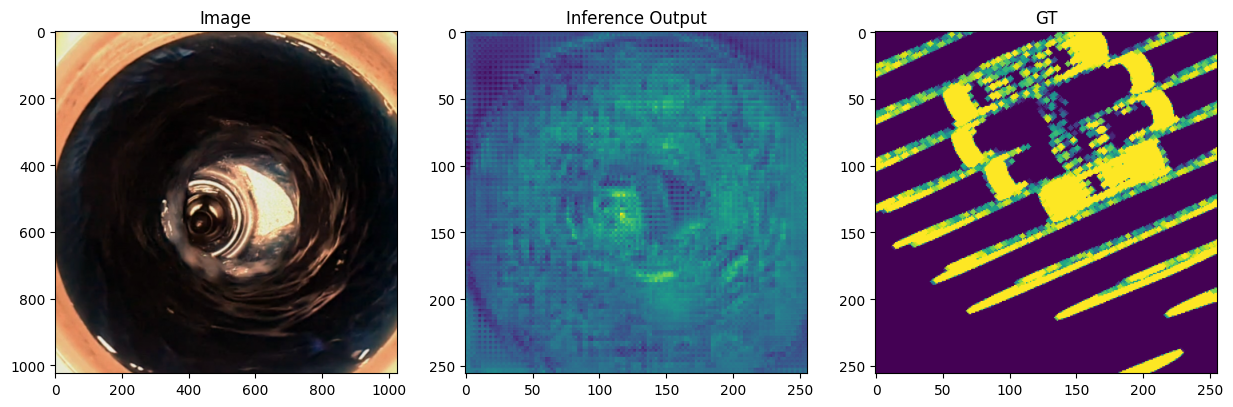

In [18]:
# Inference for val_set
filename = "00029_p4"
test_image = cv2.imread(f"processed_data/images/{filename}.png", cv2.IMREAD_COLOR)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_gt = cv2.imread(f"processed_data/masks/{filename}.png", cv2.IMREAD_GRAYSCALE)

#Inference for real image
test_image = cv2.imread("test.jpg", cv2.COLOR_BGR2RGB)
test_image = test_image[00:1024, 000:1024]

#Inference
vortex_model.cuda()
transformed = transform(image=test_image)['image']
batched_input = [{"image": transformed.cuda(), "original_size": (256, 256)}]  # FIXME: Check if this is the right way to pass the input
pred_mask = vortex_model(batched_input=batched_input, multimask_output=False)[0]["masks"]
pred_mask = pred_mask.squeeze().detach().cpu().numpy()
# pred_mask = (pred_mask > 0.5)
# predictor.set_image(np.array(test_image))

# my_ouput_mask, _, my_ouput_prob = predictor.predict(multimask_output=False)
# my_ouput_mask = np.array(my_ouput_mask.transpose(1, 2, 0), dtype=np.float32)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_image)
axes[0].set_title("Image")
axes[1].imshow(pred_mask)
axes[1].set_title("Inference Output")
axes[2].imshow(test_gt)
axes[2].set_title("GT")